# Solubility prediction for organic chemicals

Aqueous solubility is one of the key parameters defining a molecular drug activity.

In this notebook, we will develop models to predict the solubility of organic molecules in water based on their physiochemical
properties. 

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

The data was taken from the database created by Schaper and Raevskaja:
https://doi.org/10.1021/ci400692n

In [67]:
solubility=pd.read_excel(r'solubility.xlsx')

In [68]:
solubility.head()

,Formula,name,Molecular weight,S(g/L),S(M/L),"Tmp, C",pK1,pK2,pK3,f(ui),logS,"T measmt, C",logP,alpha
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,35.10,0.398,56.0,NaN,NaN,NaN,1.0,-0.40,25.0,1.108,10.586
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,7.31,0.100,35.0,NaN,NaN,NaN,1.0,-1.00,25.0,1.013,8.352
2,C1OCOCO1,"1,3,5-TRIOXANE",90.079,176.00,1.950,64.0,NaN,NaN,NaN,1.0,0.29,25.0,-0.446,7.416
3,CC(N)=O,ACETAMIDE,59.068,2250.00,38.000,80.0,NaN,NaN,NaN,1.0,1.58,25.0,-0.832,6.075
4,CC(O)CNCC(C)O,BIS(2-HYDROXYPROPYL)AMINE,133.191,860.00,6.460,44.5,8.97,NaN,NaN,1.0,0.81,25.0,-0.540,14.409


In [69]:
solubility.shape

(2615, 14)

In [11]:
solubility.columns

Index(['Formula', 'name', 'Molecular weight', 'S(g/L)', 'S(M/L)', 'Tmp, C',
       'pK1', 'pK2', 'pK3', 'f(ui)', 'logS', 'T measmt, C', 'logP', 'alpha'],
      dtype='object')

The data contains the following columns:
    
   **Formula**  contains a Simplified Molecular Input Line Entry System,” which is used to translate a\
   chemical's three-    dimensional structure into a string of symbols;\
   **name** is the IUPAC name of the compound;\
   **Molecular wight** contains molecular weight of a molecule;\
   **S(g/L)** is a solubility in grams per liter;\
   **S(M/L)** is a solubility in mole per liter;\
   **logS** is the natural logarithm of molar solubility;\
   **Tmp, C** is the temperature of the melting point of a substance;\
   **T measmt, C** is the temperature at which the solubility was measured;\
   **logP** is the value of octanol–water partition coefficient;\
   **pK1**, **pK2** and **pK3** are -log of corresponding constants of dissociation;\
   **f(ui)** - fraction un-ionized;\
   **alpha** -molecular polarizability.

In [12]:
solubility.dtypes

Formula              object
name                 object
Molecular weight    float64
S(g/L)              float64
S(M/L)              float64
Tmp, C              float64
pK1                 float64
pK2                 float64
pK3                 float64
f(ui)               float64
logS                float64
T measmt, C         float64
logP                float64
alpha               float64
dtype: object

Most of the variables are floats except for the chemical formula and chemical name.

## Target variable : solubility

In this project, we will use some physiochemical properties of molecules to predict their solubility in water.

The dataset contains solubility values in g/L, Mol/L, log Sexp, and log Suni : columns **S(g/L)**, **S(M/L)**,  and 
    **logS**.
    
Let us take a look at these columns.

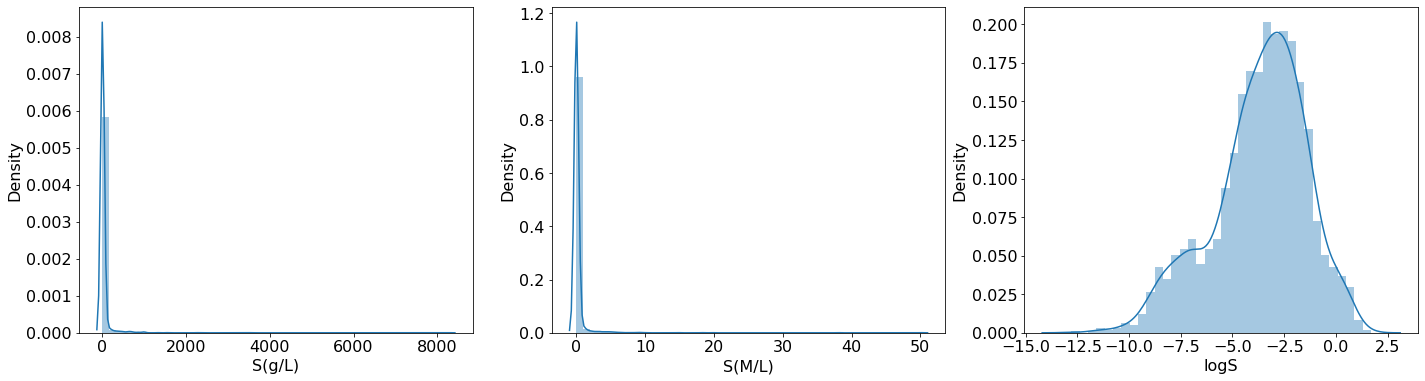

In [22]:
plt.figure(figsize=(24,6)) 
plt.rc('font', size=16)
plt.subplot(131)
sns.distplot(solubility['S(g/L)'])
plt.subplot(132)
sns.distplot(solubility['S(M/L)'])
plt.subplot(133)
sns.distplot(solubility['logS'])
plt.show()

We can see that the distributions of the absolute value of solubility ( in g/L and M/L) are not normal.
We will use the logarithmic solubility (logS) as the target variable as its distribution is closer than normal as compared to
the distributions of the absolute solubility values.

It's generally accepted that the substances with logS greater than -5 are considered to be soluble in water and the sabstances with logS lower than -5 are considered to be insoluble.

Let's create a  variable **soluble** that will indicate weather a molecule is considered to be soluble or insoluble in water accoridng to this criteria. The variable will be equal to 1 for soluble molecules and 0 for insoluble molecules.

Ww will use this variable as the target variable for our predictive models.

In [81]:
condition=(solubility['logS']>=-5)
solubility['soluble']=np.where(condition,1,0)

In [23]:
solubility['soluble'].value_counts()

1    1980
0     635
Name: soluble, dtype: int64

Our dataset contains 1980 molecules that are soluble in water and 635 molecules that are insoluble.

Let us visualise physiochemical properties present in the data set.

## Visualization of physiochemical properties

### Molecular weight

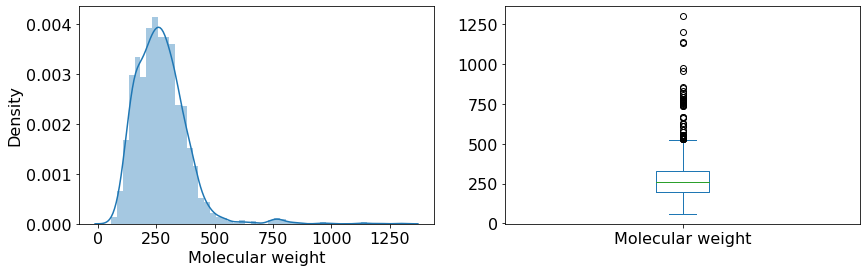

In [29]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['Molecular weight'])
plt.subplot(122)
solubility['Molecular weight'].plot.box(figsize=(14,4))
plt.show()

The distribution of the molecular weights is right skewed.

### Melting point (Tmp, C)

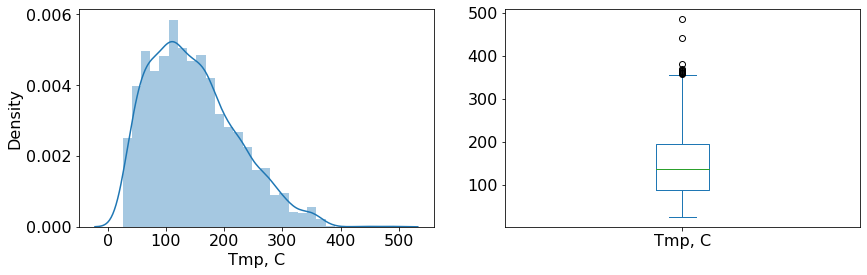

In [30]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['Tmp, C'])
plt.subplot(122)
solubility['Tmp, C'].plot.box(figsize=(14,4))
plt.show()

### Temerature of measurement

In [32]:
solubility['T measmt, C'].describe()

count    2615.000000
mean       23.968489
std         2.376038
min        20.000000
25%        22.000000
50%        25.000000
75%        25.000000
max        30.000000
Name: T measmt, C, dtype: float64

The solubility of the substances was measured at 20-30 Celcius degree.

### Octanol-water partitioning coefficient

The octanol-water partitioning coefficient (P) describes the distribution of the substance between aqueous (polar) and 
n-octanol (non-polar) solvents and is defined by the relation of the substance concentration in water and in n-octanol.

Let us visualize the natural logarithm of the partitioning coefficient (log(P)) of the substances in our data set.

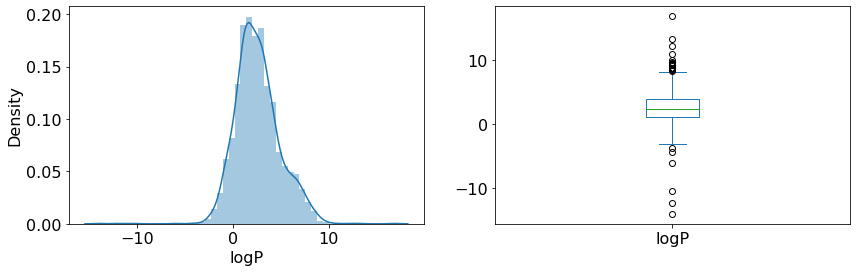

In [34]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['logP'])
plt.subplot(122)
solubility['logP'].plot.box(figsize=(14,4))
plt.show()

### Dissociation constants

Dissociation constant (K) define the extent to which a molecule can dissciate into ions in water.
K1 is the constant for the first step dissociation from neutral molecule to one cation and one anion.
K2 is the constant for the second step dissociation from an ion formed in the first step to another cation and anion.
K3 is the constant for the third step dissociation.

pK1, pK2 and pK3 are the negative logarithms of the dissociation constants (pK=-logK).

Most of the molecule have only one step of dissociation.
Let us visualize the distributions of the constants.

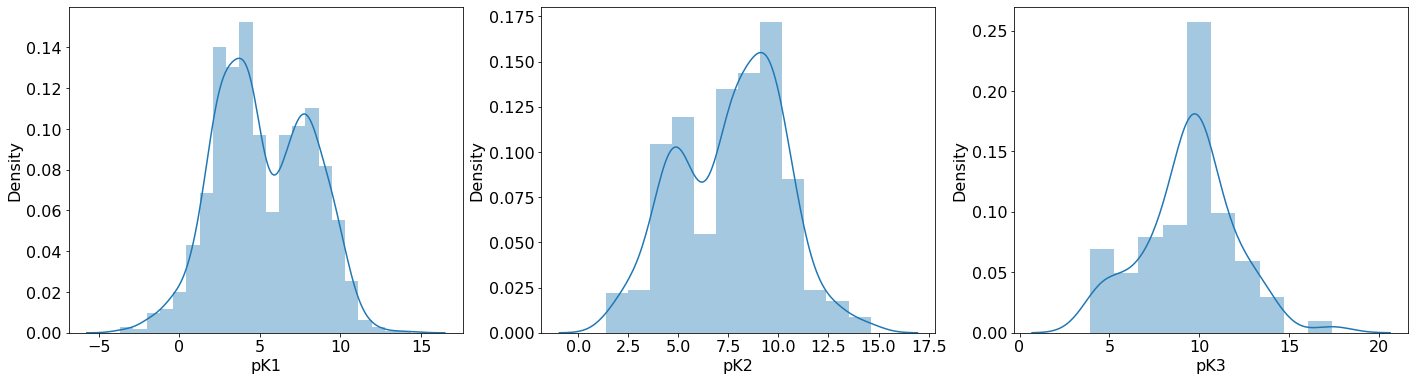

In [35]:
plt.figure(figsize=(24,6)) 
plt.rc('font', size=16)
plt.subplot(131)
sns.distplot(solubility['pK1'])
plt.subplot(132)
sns.distplot(solubility['pK2'])
plt.subplot(133)
sns.distplot(solubility['pK3'])
plt.show()

### Un-ionized fraction

Text(0.5, 0, 'f(ui)')

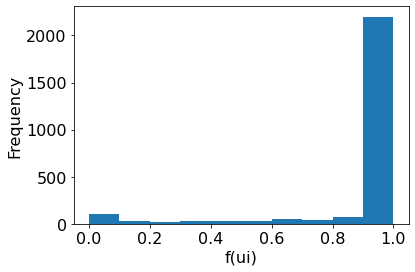

In [41]:
solubility['f(ui)'].plot(kind='hist')
plt.xlabel('f(ui)')

For most of the molecules f(ui)=1 (the un-ionized fraction = 1) so they are entirely in un-ionized form.

### Polarizability

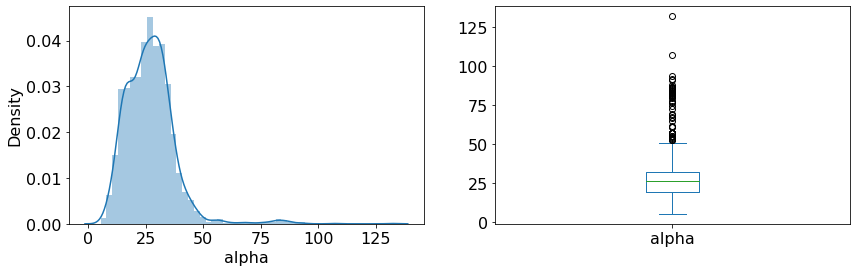

In [42]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['alpha'])
plt.subplot(122)
solubility['alpha'].plot.box(figsize=(14,4))
plt.show()

## Solubility vs. physiochemical properties

## Hypothesis stetement

We can make several hypothesis about the relationship between certain physiochemical qualities of a substance with
the substance solubility in water. For example:
    
1.There should be a relationship between the octanol-water partinioning coefficient and the solubility of a substance.
  Because one can assume that the higher is the solubility in water, the higher fraction of a sabstance would be in water
  rather than in organic octanol. And the higher the fraction in octanol the lower should be the solubility in water.
  So the higher is the partitioning coefficient the lower is the solubility.
  
2.A volume-related term (molecular polarizability α) was experimentally found to have an essential negative contribution 
  to solubility. The lower polarizability the higher solubility in polar water.
 
3.Water is a polar solvent so one can assume that the higher unionized fraction f(ui) the lower solubility in polar 
   water   solvent

4.One can also assume that the higher molecular weight the lower solubility because it is more difficult for a large molecule
  to dissolve.

5.The higher dissociation constants the higher solubility.
    
Let us make the pairplots with logS vs. physiochemical variable which will help us to explore all these hypothesis.

<Figure size 144x1800 with 0 Axes>

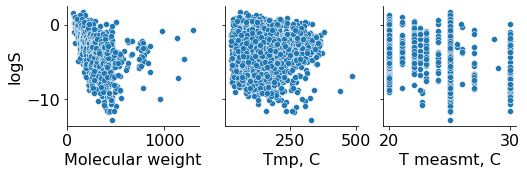

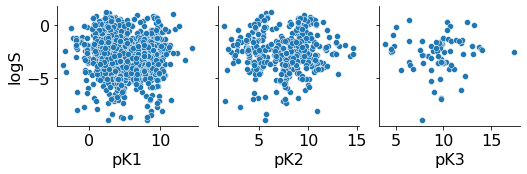

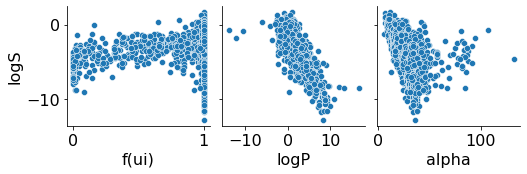

In [60]:
plt.figure(figsize=(2, 25))
sns.pairplot(data=solubility,
                  x_vars= ['Molecular weight', 'Tmp, C','T measmt, C'],
                  y_vars=['logS'])
sns.pairplot(data=solubility,
                  x_vars= ['pK1', 'pK2', 'pK3'],
                  y_vars=['logS'])
sns.pairplot(data=solubility,
                  x_vars= ['f(ui)', 'logP', 'alpha'],
                  y_vars=['logS'])
plt.show()

From the pairplots we can infer the following information:
    
-For the molecules with the molecular weight below 500, logS overally decreases with the increment in molecular wight.
For the molecules with higher moleculatr weight there is no clear trend in relationship between solubility and molecular weight.

-There is no clear trend in the relationship between logS and melting temperature (Tmp, C), measurement temperature 
(T measmt, C), dissociation constants (pK1,pK2,pK3), the un-ionized fractio (f(ui)).

-There seems to be a strong negative linear relationship between logS and the octanol-water partitioning coefficient logP.

- For the molcules with lower values of polarizability (alpha) there seems to be a linear trend in the relationship with logS.

<AxesSubplot:>

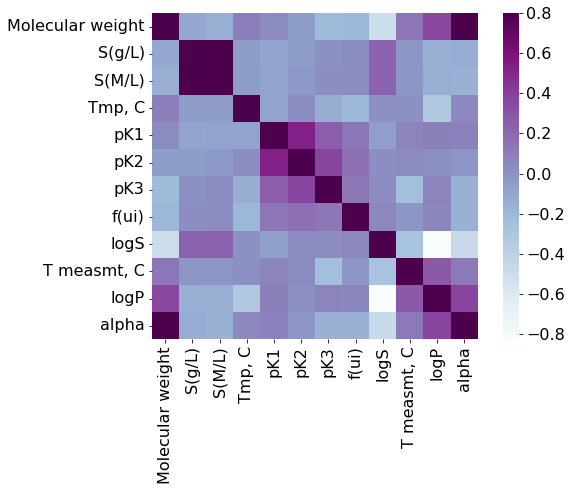

In [53]:
matrix=solubility.drop('soluble',axis=1).corr()
f,ax=plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap='BuPu')

We can impute from the correlation matrix plot that there is a high negative correlation between logS and logP. There is also 
negative correlation between logS and Molecular weight and polarizability (alpha).

Now, let us transform the data and generate new features that we can use for predictive modelling.

## Missing values treatment

In [82]:
data=solubility.copy()

In [83]:
data.isnull().sum()

Formula                0
name                   0
Molecular weight       0
S(g/L)                 0
S(M/L)                 0
Tmp, C               263
pK1                 1232
pK2                 2197
pK3                 2540
f(ui)                  8
logS                   0
T measmt, C            0
logP                   0
alpha                  0
soluble                0
dtype: int64

There are missing values for the melting point variable (Tmp, C), the dissociation constant variables(pK1, pK2 and pK3) and
the variable that defines the un-ionization fraction  (f(ui)).

Most of the molecules have only one constant of dissociation. In general, the second and the third steps of the dissociation
happen in lesser extent than in the first step.

We will drop the variables pK2 and pK3 and we will impute the misssing pK1 values with the median.
Additionally, we will impute f(ui) and Tmp, C values with their corresponding median values.

Finally, we will drop the absolute solubility values S(g/L) and S(M/L).

In [84]:
data=data.drop(['S(g/L)','S(M/L)','pK2','pK3'],axis=1)

In [85]:
data['pK1'].fillna(data['pK1'].median(),inplace=True)
data['f(ui)'].fillna(data['f(ui)'].median(),inplace=True)
data['Tmp, C'].fillna(data['Tmp, C'].median(),inplace=True)

In [86]:
data.isnull().sum()

Formula             0
name                0
Molecular weight    0
Tmp, C              0
pK1                 0
f(ui)               0
logS                0
T measmt, C         0
logP                0
alpha               0
soluble             0
dtype: int64

In [87]:
data.shape

(2615, 11)

## Feature engineering

Now, we will use the information about the chemical structure of molecules available through the variable Formula to
generate new features that can affect aqueous solubility of a molecule.

### Charge

One can assume that charged molcules should have higher solubility in water since water is a polar sovent.
Charged molecules contain regions with positive charge and an equal amount of negatively charged regions in order to
resulting charge to be 0.

The number of charged and uncharged molecules:
0    2430
1     185
Name: charge, dtype: int64


<AxesSubplot:xlabel='charge'>

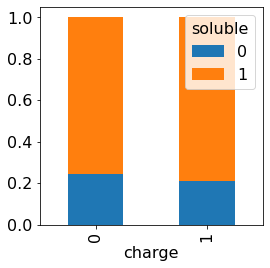

In [93]:
charge=[]

for i in range(2615):
    if data['Formula'][i].find('+')!=-1:
    #if data['Formula'][i].count('+')>1:
        charge.append(1)
    else:
        charge.append(0)
data['charge']=charge
print('The number of charged and uncharged molecules:')
print(data['charge'].value_counts())

charge=pd.crosstab(data['charge'],data['soluble'])
charge.div(charge.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
#,labels = {1:'yes', 0:'no'}

From the barplot we can infer that the proportion of soluble molecules is only slightly higher within charged molecules
as compared to uncharged molecules.

### Long carbon chain

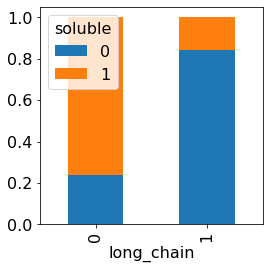

In [96]:
long_chain=[]
for i in range(2615):
    if data['Formula'][i].find('CCCCCCCCCCCCC')!=-1:
        long_chain.append(1)
    else:
        long_chain.append(0)
        
data['long_chain']=long_chain

long_chain=pd.crosstab(data['long_chain'],data['soluble'])
long_chain.div(long_chain.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

We can infer that the proportion of soluble molecules is lower among molecules with molecules containing long carbon chains.

It has been seen that the presence of the hydrogen bond acceptors like (CO, O, F, Cl etc.) has a negative impact on the
substance solubility in water. Let us generate features that reflect the presence of different hydrogen bond acceptors 
in molecules.

### Double bonds

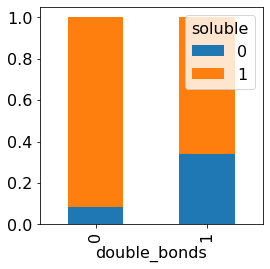

In [98]:
double_bonds=[]

for i in range(2615):
    if data['Formula'][i].count('=')>4:
        double_bonds.append(1)
    else:
        double_bonds.append(0)
        
data['double_bonds']=double_bonds

double_bonds=pd.crosstab(data['double_bonds'],data['soluble'])
double_bonds.div(double_bonds.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

We can infer that among the molecules with 5 and more double bonds, the proportion of soluble molecules is lower as compared 
to molecules with lower amount of double bonds.

### Chlorine

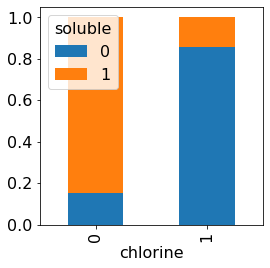

In [99]:
chlorine=[]

for i in range(2615):
    #if data['Smiles'][i].find('Cl')!=-1:
    if data['Formula'][i].count('Cl')>2:
        chlorine.append(1)
    else:
        chlorine.append(0)
        
data['chlorine']=chlorine

chlorine=pd.crosstab(data['chlorine'],data['soluble'])
chlorine.div(chlorine.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### Fluorine

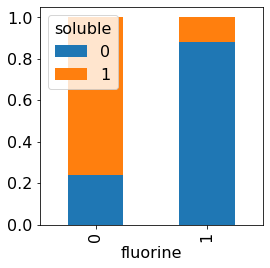

In [101]:
fluorine=[]

for i in range(2615):
    #if data['Smiles'][i].find('F')!=-1:
    if data['Formula'][i].count('F')>3:
        fluorine.append(1)
    else:
        fluorine.append(0)
        
data['fluorine']=fluorine

fluorine=pd.crosstab(data['fluorine'],data['soluble'])
fluorine.div(fluorine.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### CO

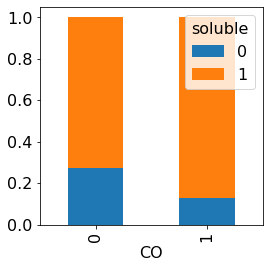

In [104]:
CO=[]

for i in range(2615):
    if data['Formula'][i].count('CO')>0:
        CO.append(1)
    else:
        CO.append(0)
        
data['CO']=CO

CO=pd.crosstab(data['CO'],data['soluble'])
CO.div(CO.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### NC

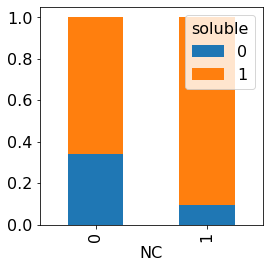

In [105]:
NC=[]

for i in range(2615):
    if data['Formula'][i].count('NC')>0:
        NC.append(1)
    else:
        NC.append(0)
        
data['NC']=NC

NC=pd.crosstab(data['NC'],data['soluble'])
NC.div(NC.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### O

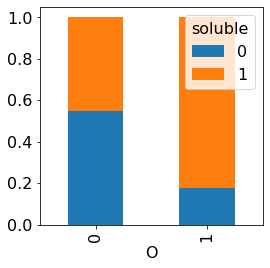

In [120]:
O=[]

for i in range(2615):
    if data['Formula'][i].count('O')>0:
        O.append(1)
    else:
        O.append(0)
        
data['O']=O

O=pd.crosstab(data['O'],data['soluble'])
O.div(O.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

## Logistic Regression

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
X=data[['Molecular weight','Tmp, C','pK1','logP','alpha','f(ui)','charge','fluorine','chlorine','long_chain','double_bonds','CO','NC']]
y=data['soluble']

In [155]:
x_train, x_test, y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [135]:
model=LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [136]:
pred_test=model.predict(x_test)
accuracy_score(y_test,pred_test)

0.9006369426751593

## k-fold cross validation

In [137]:
from sklearn.model_selection import StratifiedKFold

In [138]:
i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

In [139]:
mean_accuracy=[]

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())   


1 of kfold 5
accuracy score 0.9082217973231358

2 of kfold 5
accuracy score 0.9005736137667304

3 of kfold 5
accuracy score 0.8910133843212237

4 of kfold 5
accuracy score 0.9063097514340345

5 of kfold 5
accuracy score 0.8891013384321224

 Mean validation accuracy for this model:  0.8990439770554494


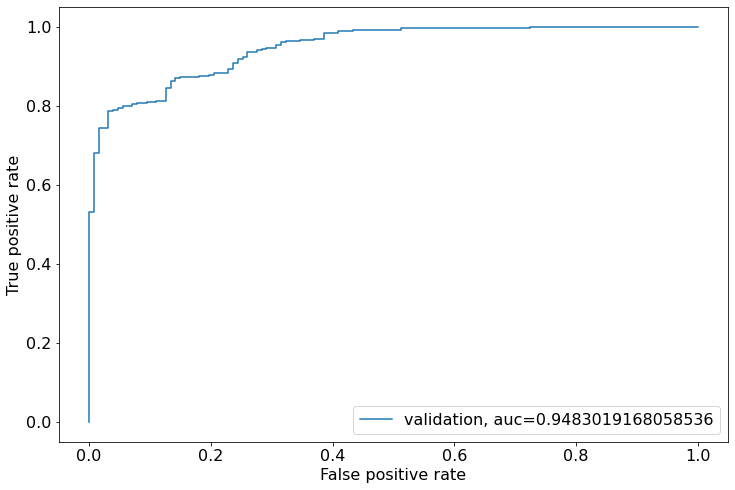

In [140]:
from sklearn import metrics

fpr,tpr,_ = metrics.roc_curve(yvl,pred)
auc=metrics.roc_auc_score(yvl,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

### Tune hyperparameters

In [141]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01,0.001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

In [142]:
grid_search.best_estimator_

LogisticRegression(C=10, random_state=1, solver='liblinear')

In [143]:
model=LogisticRegression(C=10,random_state=1,solver='liblinear')
model.fit(x_train,y_train)
pred_test=model.predict(x_test)
accuracy_score(y_test,pred_test)

0.9095541401273886

In [144]:
mean_accuracy=[]

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=LogisticRegression(random_state=1,solver='newton-cg',C=0.1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())  


6 of kfold 5
accuracy score 0.9177820267686424

7 of kfold 5
accuracy score 0.9082217973231358

8 of kfold 5
accuracy score 0.9196940726577438

9 of kfold 5
accuracy score 0.9005736137667304

10 of kfold 5
accuracy score 0.8986615678776291

 Mean validation accuracy for this model:  0.9089866156787764


## Decision Tree

In [145]:
from sklearn import tree

mean_accuracy=[]

i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=tree.DecisionTreeClassifier(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())  


1 of kfold 5
accuracy score 0.892925430210325

2 of kfold 5
accuracy score 0.9005736137667304

3 of kfold 5
accuracy score 0.8833652007648184

4 of kfold 5
accuracy score 0.8891013384321224

5 of kfold 5
accuracy score 0.8986615678776291

 Mean validation accuracy for this model:  0.8929254302103251


## Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

mean_accuracy=[]

i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=RandomForestClassifier(random_state=1,max_depth=10)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())  


1 of kfold 5
accuracy score 0.9292543021032504

2 of kfold 5
accuracy score 0.9311663479923518

3 of kfold 5
accuracy score 0.9196940726577438

4 of kfold 5
accuracy score 0.9273422562141491

5 of kfold 5
accuracy score 0.9273422562141491

 Mean validation accuracy for this model:  0.9269598470363288


### Tune hyperparameter

We will try to improve accuracy by tuning hyperparameters for this model. We will use grid search to obtain the optimized hyper
parameters. Grid-search is a way to select the best of a family of hyperparameters,parametrized by a grid of parameters.

We will tune the max_depth and n_estimators parameters. max_depth decides the maximum depth of the tree and n_estimators decides
the number of trees that will be used in random forest model.

In [156]:
from sklearn.model_selection import GridSearchCV

# Provide range for max_depth from 1 to 20 with the step of 2 and from 1 to 200 with a step of 20 for n_estimators
paramgrid={'max_depth':list(range(1,30,2)),'n_estimators':list(range(1,300,20))}
#'mean_samples_split: list(range(1,9,1)
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)

In [157]:
# Fit the grid search model
grid_search.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                       23, 25, 27, 29],
                         'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161,
                                          181, 201, 221, 241, 261, 281]})

In [149]:
# Estimating the optimized value
grid_search.best_estimator_

RandomForestClassifier(max_depth=13, n_estimators=41, random_state=1)

In [182]:
mean_accuracy=[]

i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=RandomForestClassifier(random_state=1,max_depth=13,n_estimators=41,min_samples_split=3)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())  


1 of kfold 5
accuracy score 0.9407265774378585

2 of kfold 5
accuracy score 0.9311663479923518

3 of kfold 5
accuracy score 0.9139579349904398

4 of kfold 5
accuracy score 0.9311663479923518

5 of kfold 5
accuracy score 0.9196940726577438

 Mean validation accuracy for this model:  0.9273422562141491


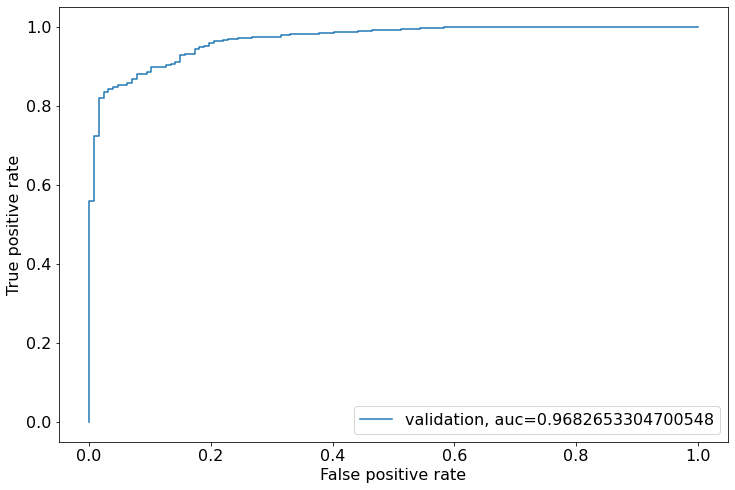

In [183]:
fpr,tpr,_ = metrics.roc_curve(yvl,pred)
auc=metrics.roc_auc_score(yvl,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

Let us find the feature importance now, i.e. which features are the most important for this problem.

<AxesSubplot:>

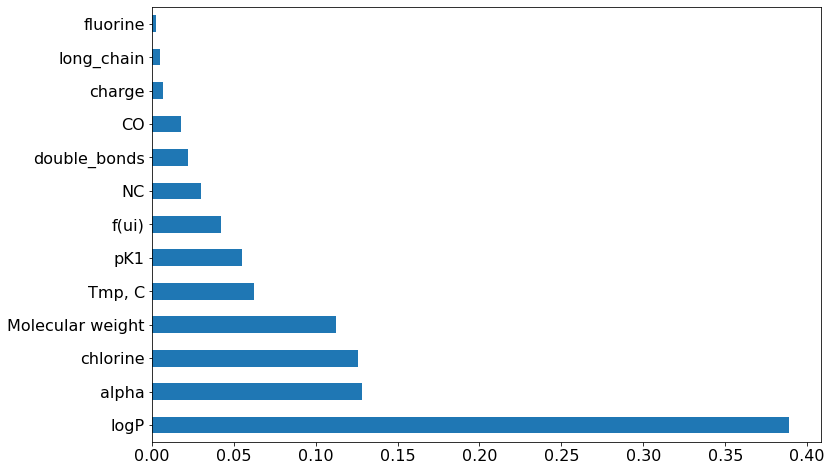

In [184]:
importances=pd.Series(model.feature_importances_,index=X.columns)
importances.sort_values(axis=0, ascending=False).plot(kind='barh',figsize=(12,8))

The most important features are octane-water partinioning coefficient, polarizability (alpha) and the presence of chlorine
in the structure so feature engineering heped us to predict the target variable.

## XGBOOST

XGBOOST is a fast and efficient algorithm.
XGBOOST works only with numeric variables. Let's have a look at the parameters we are going to use in our model.

- n_estimator: This specifies the number of trees for the model.
- max_depth: We can specify maximum depth of a tree using this parameter.

In [188]:
from xgboost import XGBClassifier

mean_accuracy=[]

i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=XGBClassifier(max_depth=10)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())  


1 of kfold 5
accuracy score 0.9177820267686424

2 of kfold 5
accuracy score 0.9177820267686424

3 of kfold 5
accuracy score 0.9120458891013384

4 of kfold 5
accuracy score 0.9139579349904398

5 of kfold 5
accuracy score 0.9063097514340345

 Mean validation accuracy for this model:  0.9135755258126196


In [189]:
grid_search=GridSearchCV(XGBClassifier(random_state=1),paramgrid)
# Fit the grid search model
grid_search.fit(x_train,y_train)
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=241,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [193]:
mean_accuracy=[]

i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)

for train_index, test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=X.iloc[train_index],X.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]
    model=XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,monotone_constraints='()',
                        n_estimators=241,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('accuracy score',score)
    mean_accuracy.append(score)
    i+=1
    pred=model.predict_proba(xvl)[:,1]
print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean())  


1 of kfold 5
accuracy score 0.9177820267686424

2 of kfold 5
accuracy score 0.9177820267686424

3 of kfold 5
accuracy score 0.9177820267686424

4 of kfold 5
accuracy score 0.9139579349904398

5 of kfold 5
accuracy score 0.9158699808795411

 Mean validation accuracy for this model:  0.9166347992351817


## Model comparison

In [212]:
model_comparison = pd.DataFrame({'model':['Logistic Regression Classifier','Logistic Regression tuned',
                          'Decision Tree', 'Random Forest', 'Random Forest tuned', 'XGBOOST', 'XGBOOST tuned'],
                  'mean validation accuracy':[0.89904,0.90899,0.89293,0.92692,0.92734,0.91358,0.91663]})

model_comparison

,model,mean validation accuracy
0,Logistic Regression Classifier,0.89904
1,Logistic Regression tuned,0.90899
2,Decision Tree,0.89293
3,Random Forest,0.92692
4,Random Forest tuned,0.92734
5,XGBOOST,0.91358
6,XGBOOST tuned,0.91663


The winner is the Random Forest model with tuned hyperparameters. With this model we achieved the highest accuracy
predicting molecule solubility in our data set.